# 门控循环单元（GRU）

在`sec_bptt`中，
我们讨论了如何在循环神经网络中计算梯度，
以及矩阵连续乘积可以导致梯度消失或梯度爆炸的问题。
下面我们简单思考一下这种梯度异常在实践中的意义：

* 我们可能会遇到这样的情况：早期观测值对预测所有未来观测值具有非常重要的意义。
  考虑一个极端情况，其中第一个观测值包含一个校验和，
  目标是在序列的末尾辨别校验和是否正确。
  在这种情况下，第一个词元的影响至关重要。
  我们希望有某些机制能够在一个记忆元里存储重要的早期信息。
  如果没有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度，
  因为它会影响所有后续的观测值。
* 我们可能会遇到这样的情况：一些词元没有相关的观测值。
  例如，在对网页内容进行情感分析时，
  可能有一些辅助HTML代码与网页传达的情绪无关。
  我们希望有一些机制来*跳过*隐状态表示中的此类词元。
* 我们可能会遇到这样的情况：序列的各个部分之间存在逻辑中断。
  例如，书的章节之间可能会有过渡存在，
  或者证券的熊市和牛市之间可能会有过渡存在。
  在这种情况下，最好有一种方法来*重置*我们的内部状态表示。

在学术界已经提出了许多方法来解决这类问题。
其中最早的方法是"长短期记忆"（long-short-term memory，LSTM）
`Hochreiter.Schmidhuber.1997`，
我们将在`sec_lstm`中讨论。
门控循环单元（gated recurrent unit，GRU）
`Cho.Van-Merrienboer.Bahdanau.ea.2014`
是一个稍微简化的变体，通常能够提供同等的效果，
并且计算`Chung.Gulcehre.Cho.ea.2014`的速度明显更快。
由于门控循环单元更简单，我们从它开始解读。

## 门控隐状态

门控循环单元与普通的循环神经网络之间的关键区别在于：
前者支持隐状态的门控。
这意味着模型有专门的机制来确定应该何时更新隐状态，
以及应该何时重置隐状态。
这些机制是可学习的，并且能够解决了上面列出的问题。
例如，如果第一个词元非常重要，
模型将学会在第一次观测之后不更新隐状态。
同样，模型也可以学会跳过不相关的临时观测。
最后，模型还将学会在需要的时候重置隐状态。
下面我们将详细讨论各类门控。

### 重置门和更新门

我们首先介绍 *重置门*（reset gate）和 *更新门*（update gate）。
**我们把它们设计成$(0, 1)$区间中的向量，
这样我们就可以进行凸组合。**

**重置门允许我们控制“可能还想记住”的过去状态的数量；
更新门将允许我们控制新状态中有多少个是旧状态的副本。**

我们从构造这些门控开始。
`fig_gru_1`描述了门控循环单元中的重置门和更新门的输入，
输入是由当前时间步的输入和前一时间步的隐状态给出。
两个门的输出是由使用sigmoid激活函数的两个全连接层给出。

![在门控循环单元模型中计算重置门和更新门](../img/gru-1.svg)

我们来看一下门控循环单元的数学表达。
对于给定的时间步$t$，假设输入是一个小批量
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本个数 $n$，输入个数 $d$），
上一个时间步的隐状态是
$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$
（隐藏单元个数 $h$）。
那么，重置门 $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ 和
更新门 $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ 的计算如下所示：

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r)\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z)
\end{aligned}
$$

其中 $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$
和 $\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ 是权重参数，
$\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ 是偏置参数。
请注意，在求和过程中会触发广播机制
（请参阅`subsec_broadcasting`）。
我们使用sigmoid函数（如`sec_mlp`中介绍的）
将输入值转换到区间 $(0, 1)$。

### 候选隐状态

接下来，让我们将重置门$\mathbf{R}_t$
与`rnn_h_with_state`中的常规隐状态更新机制集成，
得到在时间步$t$的*候选隐状态*（candidate hidden state）
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$。

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h)$$

其中 $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$
和 $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$ 是权重参数，
$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$ 是偏置项，
符号 $\odot$ 是 Hadamard 积（按元素乘积）运算符。
在这里，我们使用 tanh 非线性激活函数来确保候选隐状态中的值保持在区间 $(-1, 1)$ 中。

与`rnn_h_with_state`相比，
`gru_tilde_H`中的 $\mathbf{R}_t$ 和 $\mathbf{H}_{t-1}$
的元素相乘可以减少以往状态的影响。
每当重置门 $\mathbf{R}_t$ 中的项接近 $1$ 时，
我们恢复一个如`rnn_h_with_state`中的普通的循环神经网络。
对于重置门 $\mathbf{R}_t$ 中所有接近$0$的项，
候选隐状态是以 $\mathbf{X}_t$ 作为输入的多层感知机的结果。
因此，任何预先存在的隐状态都会被*重置*为默认值。

`fig_gru_2`说明了应用重置门之后的计算流程。

![在门控循环单元模型中计算候选隐状态](../img/gru-2.svg)

### 隐状态

上述的计算结果只是候选隐状态，我们仍然需要结合更新门 $\mathbf{Z}_t$ 的效果。
这一步确定新的隐状态 $\mathbf{H}_t \in \mathbb{R}^{n \times h}$
在多大程度上来自旧的状态 $\mathbf{H}_{t-1}$ 和
新的候选状态 $\tilde{\mathbf{H}}_t$。
更新门 $\mathbf{Z}_t$ 仅需要在
$\mathbf{H}_{t-1}$ 和 $\tilde{\mathbf{H}}_t$
之间进行按元素的凸组合就可以实现这个目标。
这就得出了门控循环单元的最终更新公式：

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t$$

每当更新门 $\mathbf{Z}_t$ 接近 $1$ 时，模型就倾向只保留旧状态。
此时，来自 $\mathbf{X}_t$ 的信息基本上被忽略，
从而有效地跳过了依赖链条中的时间步 $t$。
相反，当 $\mathbf{Z}_t$ 接近 $0$ 时，
新的隐状态 $\mathbf{H}_t$ 就会接近候选隐状态 $\tilde{\mathbf{H}}_t$。
这些设计可以帮助我们处理循环神经网络中的梯度消失问题，
并更好地捕获时间步距离很长的序列的依赖关系。
例如，如果整个子序列的所有时间步的更新门都接近于 $1$，
则无论序列的长度如何，在序列起始时间步的旧隐状态都将很容易保留并传递到序列结束。

`fig_gru_3`说明了更新门起作用后的计算流。

![计算门控循环单元模型中的隐状态](../img/gru-3.svg)

总之，门控循环单元具有以下两个显著特征：

* 重置门有助于捕获序列中的短期依赖关系。
* 更新门有助于捕获序列中的长期依赖关系。

### 附：重置门和更新门的理解

$R_t$ 和 $Z_t$ 都是根据过去的状态 $H_{t-1}$ 和当前输入 $X_t$ 计算得到的 [0,1] 之间的量。

- $R_t$ 首先与 $H_{t-1}$ 进行元素积，由于 $R_t$ 内部都是 [0,1] 的变量，因此是对过去的状态 $H_{t-1}$ 进行一次选择，$R_t$ 在某个位置的值越趋近于0，则表示这个位置的过去信息越倾向于被丢弃，反之保留。随后与 $X_t$ 一起构成候选隐藏变量 $\tilde{H}_t$。同样由于 $R_t$ 的值在 [0,1] 中，**它只会削弱过去的状态，而不会增强，因此被称为遗忘门（或重置门，重置过去的状态）。**

- $Z_t$ 被称为更新门，因为它控制了隐藏状态的更新。假如 $Z_t$ 全为 1，则 $H_t$ 将完全保留上一个时间的状态 $H_{t-1}$；反之，则全盘采用当前时刻的候选隐藏变量 $\tilde{H}_t$。或许各位会有疑问，感觉 $R_t$ 已经对过去有所选择，为何还要加上 $Z_t$ 多此一举。个人认为，$Z_t$ 实际上是对当前进行选择，根据老师的例子，如果一个序列中已经有很多的“猫”，那么再输入猫，实际上对于网络的正收益不大，可以抛弃，**而 $R_t$ 只能选择过去，不能抛弃当前，而 $Z_t$ 可以。**

总而言之，GRU通过两个门控网络，根据过去状态和当前输入，一方面对过去状态进行选择，一方面对当前状态也进行选择。

## 从零开始实现

为了更好地理解门控循环单元模型，我们从零开始实现它。
首先，我们读取`sec_rnn_scratch`中使用的时间机器数据集：

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 初始化模型参数

下一步是初始化模型参数。
我们从标准差为$0.01$的高斯分布中提取权重，
并将偏置项设为$0$，超参数`num_hiddens`定义隐藏单元的数量，
实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。

In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():  # 同时生成三个参数
        return (normal((num_inputs, num_hiddens)),  # X * W
                normal((num_hiddens, num_hiddens)),  # H * W
                torch.zeros(num_hiddens, device=device))  # 偏置向量

    W_xz, W_hz, b_z = three()  # 更新门(Z)参数
    W_xr, W_hr, b_r = three()  # 重置门(R)参数
    W_xh, W_hh, b_h = three()  # 候选隐状态(H_tilda)参数

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型

现在我们将定义隐状态的初始化函数`init_gru_state`。
与`sec_rnn_scratch`中定义的`init_rnn_state`函数一样，
此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。

In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

现在我们准备定义门控循环单元模型，
模型的架构与基本的循环神经网络单元是相同的，
只是权重更新公式更为复杂。

注：* 是哈达码积，对应位置按元素乘；@ 是矩阵乘法。

In [4]:
def gru(inputs, state, params):  # inputs -- (时间步数, 批量大小, 输入维度) 
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:  # 每次处理一个时间步的数据
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)  # 重置门R（Reset Gate）
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)  # 更新门Z（Update Gate）
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)  # 候选隐状态H_tilda
        H = Z * H + (1 - Z) * H_tilda  # 隐状态H更新
        Y = H @ W_hq + b_q  # 输出层计算
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### 训练与预测

训练和预测的工作方式与`sec_rnn_scratch`完全相同。
训练结束后，我们分别打印输出训练集的困惑度，
以及前缀“time traveler”和“traveler”的预测序列上的困惑度。

perplexity 1.1, 85175.7 tokens/sec on cpu
time travellerit s against reason said filbywhat this four dimen
traveller with a slight accession ofcheerfulness really thi


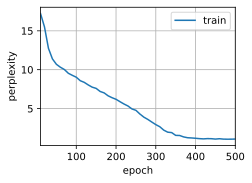

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)  # 发现 cpu 训的速度更快

## 简洁实现

高级API包含了前文介绍的所有配置细节，
所以我们可以直接实例化门控循环单元模型。
这段代码的运行速度要快得多，
因为它使用的是编译好的运算符而不是Python来处理之前阐述的许多细节。

perplexity 1.0, 69465.4 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


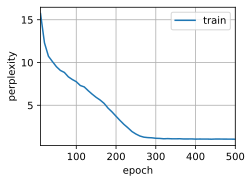

In [6]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)  # RNN 中 -- rnn_layer = nn.RNN(len(vocab), num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 小结

* 门控循环神经网络可以更好地捕获时间步距离很长的序列上的依赖关系。
* 重置门有助于捕获序列中的短期依赖关系。
* 更新门有助于捕获序列中的长期依赖关系。
* 重置门打开时，门控循环单元包含基本循环神经网络；更新门打开时，门控循环单元可以跳过子序列。
* 门控机制可以有效缓解梯度消失问题。

## 练习

1. 假设我们只想使用时间步$t'$的输入来预测时间步$t > t'$的输出。对于每个时间步，重置门和更新门的最佳值是什么？
2. 调整和分析超参数对运行时间、困惑度和输出顺序的影响。
3. 比较`rnn.RNN`和`rnn.GRU`的不同实现对运行时间、困惑度和输出字符串的影响。
4. 如果仅仅实现门控循环单元的一部分，例如，只有一个重置门或一个更新门会怎样？

[Discussions](https://discuss.d2l.ai/t/2763)
